In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
from tensorflow import keras

# Data

In [4]:
df = pd.read_csv('MRTSSM448USN.csv', parse_dates = True, index_col = 'DATE')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 341 entries, 1992-01-01 to 2020-05-01
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   MRTSSM448USN  341 non-null    int64
dtypes: int64(1)
memory usage: 5.3 KB


In [6]:
df.head(5)

,MRTSSM448USN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [7]:
df.columns = ['Sales']

In [8]:
# last 7 values look like outliers
df = df[:334] 

<AxesSubplot:xlabel='DATE'>

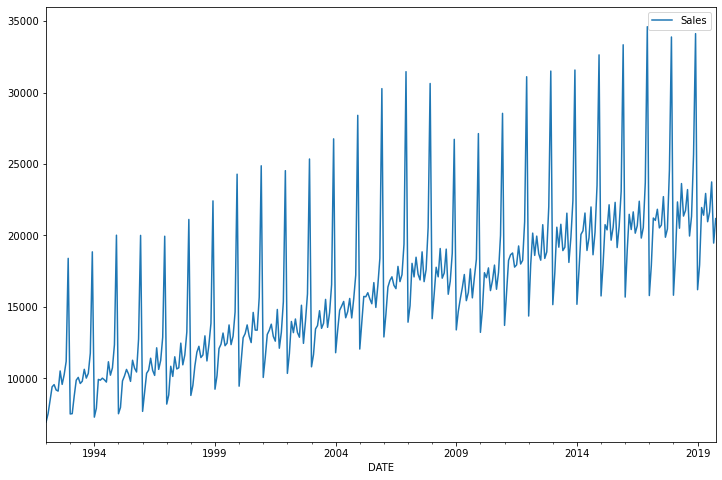

In [9]:
df.plot(figsize = (12,8))

In [10]:
test_size = 18
test_ind = len(df) - test_size

In [11]:
train = df.iloc[:test_ind]
test  = df.iloc[test_ind:]

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
scaler.fit(train)

MinMaxScaler()

In [15]:
scaled_train = scaler.transform(train)

In [16]:
scaled_test  = scaler.transform(test)

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length = length, batch_size = 1)

In [19]:
X, y = generator[0]

In [20]:
X

array([[[0.        ],
        [0.02117588],
        [0.0555415 ],
        [0.08900372],
        [0.09467712],
        [0.08108987],
        [0.0782351 ],
        [0.12918729],
        [0.09521917],
        [0.11982799],
        [0.15354316],
        [0.41401366]]])

In [21]:
y

array([[0.02038088]])

# Model

In [22]:
n_features = 1

In [23]:
model = keras.models.Sequential([
    keras.layers.LSTM(100, activation = 'relu', input_shape = (length, n_features)),
    keras.layers.Dense(1)
])

In [24]:
model.compile(optimizer='adam', loss = 'mse')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [26]:
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

In [28]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size = 1)

In [29]:
model.fit_generator(generator, epochs = 20, validation_data = validation_generator, callbacks = [early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 304 steps, validate for 6 steps
Epoch 1/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0270 - val_loss: 0.0217
Epoch 2/20
304/304 [==============================] - 3s 8ms/step - loss: 0.0192 - val_loss: 0.0029
Epoch 3/20
304/304 [==============================] - 3s 8ms/step - loss: 0.0115 - val_loss: 7.7419e-04
Epoch 4/20
304/304 [==============================] - 3s 8ms/step - loss: 0.0054 - val_loss: 0.0031
Epoch 5/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0028 - val_loss: 0.0016


In [30]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

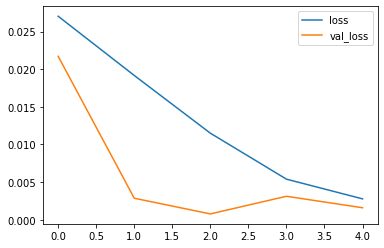

In [31]:
losses.plot()

In [32]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

In [33]:
true_pred = scaler.inverse_transform(test_predictions)

In [34]:
test['Pred'] = true_pred

C:\Users\dixq1\anaconda3\envs\exam_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='DATE'>

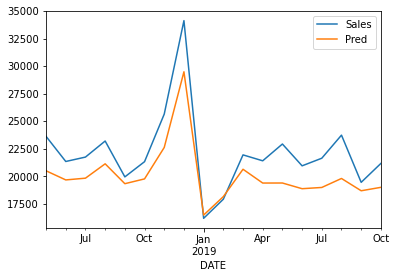

In [35]:
test.plot()

In [36]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [37]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size = 1)

In [38]:
model_full = keras.models.Sequential([
    keras.layers.LSTM(100, activation = 'relu', input_shape=(length, n_features)),
    keras.layers.Dense(1)
])

In [39]:
model_full.compile(loss = 'mse', optimizer = 'adam')

In [40]:
model_full.fit_generator(generator, epochs = 20, validation_data = validation_generator, callbacks = [early_stop])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 322 steps, validate for 6 steps
Epoch 1/20
322/322 [==============================] - 4s 12ms/step - loss: 0.0226 - val_loss: 0.0025
Epoch 2/20
322/322 [==============================] - 3s 9ms/step - loss: 0.0149 - val_loss: 0.0025
Epoch 3/20
322/322 [==============================] - 3s 8ms/step - loss: 0.0074 - val_loss: 0.0020
Epoch 4/20
322/322 [==============================] - 3s 8ms/step - loss: 0.0051 - val_loss: 5.4701e-04
Epoch 5/20
322/322 [==============================] - 3s 9ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 6/20
322/322 [==============================] - 3s 8ms/step - loss: 0.0025 - val_loss: 7.4696e-04


In [44]:
test_predictions = []

periods = 12

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

In [45]:
true_pred = scaler.inverse_transform(test_predictions)

In [46]:
test['Pred_Full'] = true_pred

C:\Users\dixq1\anaconda3\envs\exam_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='DATE'>

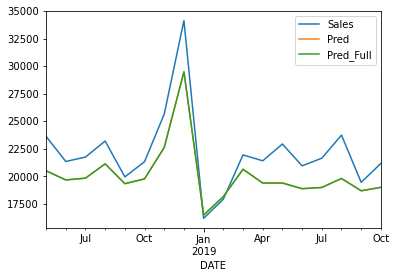

In [47]:
test.plot()